#### authors: Rafael Dousse, Eva Ray, Massimo Stefani

# PW4 - Linear Regression

## Imports

In [1]:
import random
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

## Load data

Define the path to the file containing the data

In [2]:
datafile = "lausanne-appart.csv"

Read the data

In [3]:
dataset = pd.read_csv(datafile)

Display first rows

In [4]:
dataset.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


## Exercise 1 - Visualize the data

a) Plot a histogram to visualize the distribution of the renting price

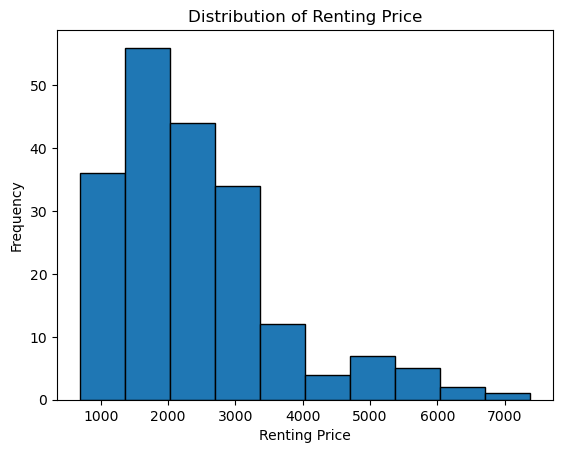

In [6]:
# Your code here
plt.hist(dataset['rent_price'], edgecolor='black')
plt.title('Distribution of Renting Price')
plt.xlabel('Renting Price')
plt.ylabel('Frequency')
plt.show()

b) Plot a histogram to visualize the distribution of the living area

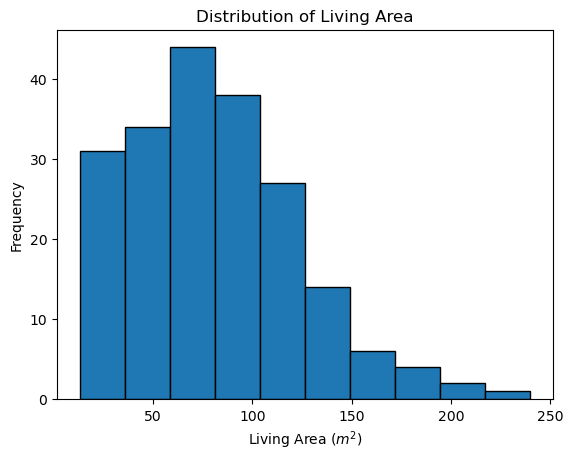

In [7]:
# Your code here
plt.hist(dataset['living_area'], edgecolor='black')
plt.title('Distribution of Living Area')
plt.xlabel('Living Area ($m^2$)')
plt.ylabel('Frequency')
plt.show()

c) Plot a scatter plot of renting price as a function of living area

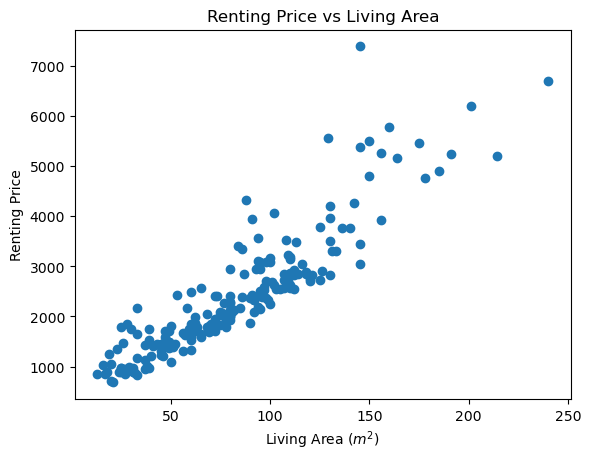

In [8]:
# Your code here
plt.scatter(dataset['living_area'], dataset['rent_price'])
plt.title('Renting Price vs Living Area')
plt.xlabel('Living Area ($m^2$)')
plt.ylabel('Renting Price')
plt.show()

## Exercise 2 - Normal equations for linear regression

a) Implement the closed form solution to this problem using the following normal equation:

<div><div style="display: table-cell; width: 100%;"><center>$\theta = (X^{T}X)^{-1}X^{T}\vec{y}$</center></div><div style="display: table-cell; width: 100%;">$(3)$</div></div>

Assuming $x$ is the living area and $y$ is the renting price. Use `numpy` for the vector operations. Plot the computed line on top of the scatter plot of exercise 1.

In [8]:
# Your code here

b) Compute the overall cost value according to the following equation:

<div><div style="display: table-cell; width: 100%;"><center>$J(\theta) = \frac{1}{2N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n})^{2}$</center></div><div style="display: table-cell; width: 100%;">$(2)$</div></div>

In [9]:
# Your code here

## Exercise 3 - Gradient descent for linear regression

Implement the _full batch_ gradient descent algorithm for the previous problem. As seen in the
theory, the update rules are:

<div><div style="display: table-cell; width: 100%;"><center>$\theta_{0} \leftarrow \theta_{0} - \alpha \frac{1}{N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n})$</center></div><div style="display: table-cell; width: 100%;">$(6)$</div></div>

<div><div style="display: table-cell; width: 100%;"><center>$\theta_{1} \leftarrow \theta_{1} - \alpha \frac{1}{N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n}) x_{n,1}$</center></div><div style="display: table-cell; width: 100%;">$(7)$</div></div>

**Remark** You need to iterate several times over the training set. If you have problems of convergence, you need to use a smaller value of $\alpha$. Values such as $0.000001$ are common.

In [10]:
# Your code here

a) Plot the cost value (Equation 2) as a function of the iterations. What do you observe?

In [11]:
# Your code here

_Your answer here_

b) Imagine a stopping criterion, i.e. when do we stop iterating on the training set?

_Your answer here_

c) Plot the computed line $h_{\theta}(\mathbf{x})$ on top of the scatter plot of exercise 1.

In [12]:
# Your code here

d) Compute the final cost value according to Equation 2 and compare it to the one of exercise 2. What can you conclude?

In [13]:
# Your code here

_Your answer here_

## Exercise 4 - Stochastic gradient descent for linear regression

Implement the stochastic gradient descent algorithm for the previous problem. As seen in the theory, the update rules are:

<div><div style="display: table-cell; width: 100%;"><center>$\theta_{i} \leftarrow \theta_{i} - \alpha (h_{\theta}(\mathbf{x}_{n}) - y_{n}) x_{n,i}$</center></div><div style="display: table-cell; width: 100%;">$(8)$</div></div>

In [14]:
# Your code here

a) Plot the computed line $h_{\theta}(\mathbf{x})$ on top of the scatter plot of exercise 1.

In [15]:
# Your code here

b) How many samples do you need to visit for reaching the convergence?

_Your answer here_

c) What kind of stopping criterion could we use here?

_Your answer here_

d) Compute the final cost value according to Equation 2 and compare it to the one of exercise 2 and 3. What can you conclude?

In [16]:
# Your code here

_Your answer here_

## Exercise 5 - Review questions

a) The linear regression has a mathematical _closed form_ solution. Then, in which conditions would we prefer a gradient descent algorithm to compute the regression model?

_Your answer here_

b) Outliers in a data set can be defined as values that are out of the "usual" range in comparison with other values. They typically come from noise or anomalies in the data capturing process. What is the impact of an outlier in the stochastic gradient descent process? What if we have many outliers? _Hint_: look at the equation of the MSE, and to the equation of the update rule.

_Your answer here_

c) In the case of stochastic gradient descent, what is the danger of having a too large or too small $\alpha$ value? Could you think of a better (more advanced) strategy as the one stated in Slide 36?

_Your answer here_

d) Let's assume we expect that the target variable $y$ has a dependency to the square and to the cube of one of the feature $x_d$ in our multi-variable training set $(x_1, \ldots, x_d, \ldots, x_D)$. How would you proceed? Do we need to take precautions in terms of numerical stability?

_Your answer here_

e) _Advanced_. Could we use a descent algorithm without computing the gradient? If yes, give a pseudo code of the algorithm to find $(\theta_{0}, \theta_{1})$ using a linear regression $h_{\theta}(x) = \theta_0 + \theta_1 x$.

_Your answer here_